# Rapid prototyping of fMRI models with `brainiak.matnormal`

## Warmup: regression
Unlike many of the other tools in `brainiak`, the `brainiak.matnormal` package is only a little bit about specific methods and a lot about letting you try new ideas and method variants quickly. If the variants are useful, they can be sped up and made neater for broader consumption. 

To understand how simple it is to prototype new matrix-normal models, consider first simple linear regression: 

$$
Y \sim \mathcal{MN}(XB, I, I), 
$$

where $Y$ is a centered TRs by voxels matrix of brain data, $X$ is a TRs by conditions design matrix, and $B$ is a conditions by voxels coefficients matrix. Notated this way, the model is the conventional massively-univariate GLM: the activation at every voxel and every timepoint is a linear combination (aka weighted sum) of the condition coding, weighted by the coefficients -- or equivalently a weighted sum of the coefficients, with the condition codes as weights. We can generate a simple dataset and show how simple it is to fit such a model by maximum likelihood using automatically computed gradients. 

In [1]:
# Generate data
from sklearn.datasets import make_friedman1
import numpy as np
np.random.seed(1)

features = 5
voxels = 100
TRs = 50

X, _ = make_friedman1(n_samples=TRs, n_features=features, random_state=None)
B = 5* np.random.random(size=(features, voxels))
Y = X @ B + np.random.normal(size=(TRs, voxels))

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


True an estimated B correlation: 0.9562578776525819


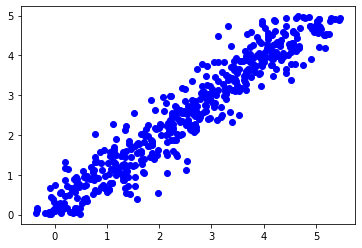

In [2]:
import tensorflow as tf
tf.random.set_seed(1)
# brainiak.matnormal.covs provides implementations of various 
# structured covariances. We will discuss this shortly. 
from brainiak.matnormal.covs import CovIdentity
# brainiak.matnormal.utils provides helpers that (mostly) make it easy
# to interface between tensorflow and scipy optimizers
from brainiak.matnormal.utils import (
    # this takes a loss function and wraps it into value and gradient
    # functions that can be used with the scipy optimizers
    make_val_and_grad, 
    # this packs trainable variables in tensorflow in the format 
    # scipy optimize rs need
    pack_trainable_vars,
    # this unpacks the train variables back to tensorflow variables
    unpack_trainable_vars
)
# brainiak.matnormal.matnormal_likelihoods provides efficient implementations
# of matrix-normal likelihoods, including marginals and conditionals
from brainiak.matnormal.matnormal_likelihoods import matnorm_logp
# what we actually use for optimization
from scipy.optimize import minimize

# Now we create the tensorflow objects we need. The covariances are independent
# since this is the univariate GLM. 
space_cov = CovIdentity(size=voxels)
time_cov = CovIdentity(size=TRs)

# this is our estimate of B, and the wrappers for X and Y. 
B_hat = tf.Variable(np.random.normal(size=(features, voxels)), name="beta")
Y_tf = tf.constant(Y)
X_tf = tf.constant(X)
# construct loss (negative log likelihood)
# note that params are ignored by this function but implicitly
# tracked by tensorflow to compute gradients
def loss(params):
    return -matnorm_logp( Y_tf - X_tf @ B_hat, time_cov, space_cov)

val_and_grad = make_val_and_grad(lossfn=loss, train_vars=[B_hat])
initial_guess = pack_trainable_vars([B_hat])
opt_results = minimize(fun=val_and_grad, x0=initial_guess, jac=True, method="L-BFGS-B")
print(opt_results.message) # check that we converged

_ = B_hat.assign(unpack_trainable_vars(opt_results.x, trainable_vars=[B_hat])[0])

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
plt.plot(B_hat.numpy().flatten(), B.flatten(), 'bo')
print(f"True an estimated B correlation: {pearsonr(B_hat.numpy().flatten(), B.flatten())[0]}")

In practice, a simple model like this could just as easily be fit using more standard tools. More interesting is if we (reasonably) assume that the noise in our data is structured, and we want to model that structure rather than try to prewhiten it, for example:

$$
\sigma_v^{-1} \sim \mathcal{InvGamma}(\alpha, \beta)\\
Y \sim \mathcal{MN}(XB, \Sigma_{AR1},\mathrm{diag}(\sigma_v)), 
$$

where $\Sigma_{AR1}$ is a structured covariance matrix with AR(1) structure, and the spatial covariance is diagonal (independent) but with varying scales for each voxel and we use an inverse-gamma prior to regularize them. Estimating this model is very similar: 

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
True an estimated B correlation: 0.9560363339613879


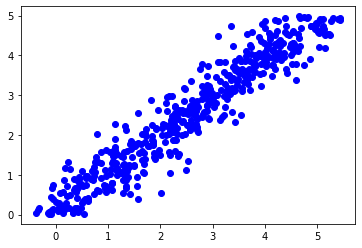

In [8]:
from brainiak.matnormal.covs import CovAR1, CovDiagonalGammaPrior
from brainiak.matnormal.utils import rmn

# generate AR(1) temporal noise that is independent in space
true_time_cov = CovAR1(size=TRs)
true_space_cov = CovDiagonalGammaPrior(size=voxels)
noise = rmn(rowcov=true_time_cov._cov, colcov=true_space_cov._cov)
Y = X @ B + noise

# This time space_cov is AR(1)
space_cov = CovDiagonalGammaPrior(size=voxels)
time_cov = CovAR1(size=TRs)

# Reset B_hat
B_hat = tf.Variable(np.random.normal(size=(features, voxels)), name="beta")

# Now we estimate B_hat, but also the AR parameters and the
# voxelwise residual variances (which the relevant
# cov objects know about and expose to us)
train_vars = [B_hat] + time_cov.get_optimize_vars() + space_cov.get_optimize_vars()

# now this loss incorporates the log-likelihood of our covariance parameters 
def loss(params):
    return -matnorm_logp( Y_tf - X_tf @ B_hat, time_cov, space_cov) - space_cov.logp - time_cov.logp

val_and_grad = make_val_and_grad(lossfn=loss, train_vars=train_vars)
initial_guess = pack_trainable_vars(train_vars)
opt_results = minimize(fun=val_and_grad, x0=initial_guess, jac=True, method="L-BFGS-B")
print(opt_results.message) # check that we converged

# assign the AR parameters as well as B
unpacked_theta = unpack_trainable_vars(opt_results.x, trainable_vars=train_vars)
for var, val in zip(train_vars, unpacked_theta):
    var.assign(val)

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
plt.plot(B_hat.numpy().flatten(), B.flatten(), 'bo')
print(f"True an estimated B correlation: {pearsonr(B_hat.numpy().flatten(), B.flatten())[0]}")

`brainiak.matnormal` provides a convenience wrapper for such regression models. It actually performs a bit better by initializing the coefficients to the generalized least-squares solution, and then optimizing from there. 

True an estimated B correlation: 0.8863502925902039


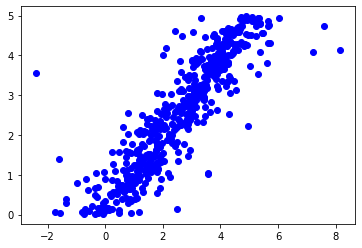

In [6]:
from brainiak.matnormal.regression import MatnormalRegression

model = MatnormalRegression(time_cov=time_cov, space_cov=space_cov)
model.fit(X, Y)
plt.plot(model.beta_.flatten(), B.flatten(), 'bo')
print(f"True an estimated B correlation: {pearsonr(model.beta_.flatten(), B.flatten())[0]}")

## Priors, marginalization and RSA

We have already introduced the idea of priors in the previous example, though in that case we were using them purely as regularization. But we can sometimes set priors in a way that lets us integrate over some nuisance parameter entirely. This marginalization is used, for example, in deriving BRSA from beta-series RSA (also available in `brainiak`). We notate the same marginalization in the matrix-normal setting next. If: 

$$
B \sim \mathcal{MN}(0, U, I)\\
Y \mid B \sim \mathcal{MN}(XB, \Sigma_{AR1},I), 
$$
then:
$$
Y \sim \mathcal{MN}(0, XUX^{T} + \Sigma_{AR1},I), 
$$

And the RSA correlation is given by dividing the RSA covariance $U$ by the featurewise variances. BRSA relies on a number of linear algebra tricks to speed up estimation, and similar tricks for the matrix-normal setting are availble in generalized form to enable MN-RSA (note that this is repeated from the `brainiak` MN-RSA example notebook): 

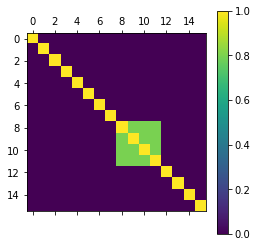

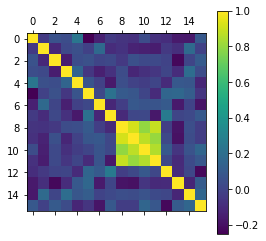

In [13]:
from scipy.stats import norm
import scipy.linalg
from scipy.special import expit as inv_logit
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt


def rmn(rowcov, colcov):
    # generate random draws from a zero-mean matrix-normal distribution
    Z = norm.rvs(norm.rvs(size=(rowcov.shape[0], colcov.shape[0])))
    return cholesky(rowcov).dot(Z).dot(cholesky(colcov))


def make_ar1_with_lowrank_covmat(size, rank):
    """ Generate a random covariance that is AR1 with added low rank structure
    """
    sigma = np.abs(norm.rvs())
    rho = np.random.uniform(-1, 0)
    offdiag_template = scipy.linalg.toeplitz(np.r_[0, 1, np.zeros(size - 2)])
    diag_template = np.diag(np.r_[0, np.ones(size - 2), 0])
    I = np.eye(size)

    prec_matrix = (I - rho * offdiag_template + rho ** 2 * diag_template) / (sigma ** 2)
    lowrank_matrix = norm.rvs(size=(size, rank))
    return np.linalg.inv(prec_matrix) + lowrank_matrix.dot(lowrank_matrix.T)


def gen_data(n_T, n_V, space_cov, time_cov):

    n_C = 16
    U = np.zeros([n_C, n_C])
    U = np.eye(n_C) * 0.6
    U[8:12, 8:12] = 0.8
    for cond in range(8, 12):
        U[cond, cond] = 1

    beta = rmn(U, space_cov)

    X = rmn(np.eye(n_T), np.eye(n_C))

    Y_hat = X.dot(beta)

    Y = Y_hat + rmn(time_cov, space_cov)

    return beta, X, Y, U


n_T = 100
n_V = 80
n_C = 16

spacecov_true = np.diag(np.abs(norm.rvs(size=(n_V))))
timecov_true = make_ar1_with_lowrank_covmat(n_T, rank=7)

true_beta, true_X, true_Y, true_U = gen_data(n_T, n_V, spacecov_true, timecov_true)
true_C = cov2corr(true_U)
plt.matshow(true_C)
plt.colorbar()
# showing off more structured covariances
from brainiak.matnormal.covs import CovUnconstrainedCholesky, CovDiagonal
from brainiak.utils.utils import cov2corr
# this efficiently computes matrix-normal marginals, marginalized over the row dimension
from brainiak.matnormal.matnormal_likelihoods import matnorm_logp_marginal_row 

space_cov = CovDiagonal(size=n_V)
time_cov = CovAR1(size=n_T)

rsa_cov = CovUnconstrainedCholesky(size=n_C)

params = (
    rsa_cov.get_optimize_vars()
    + time_cov.get_optimize_vars()
    + space_cov.get_optimize_vars()
)

# note the loss now includes a marginal logp term, plus the likelihoods of the various covariances in question
def loss(params):
    return -(
        time_cov.logp
        + space_cov.logp
        + rsa_cov.logp
        + matnorm_logp_marginal_row(
            true_Y, row_cov=time_cov, col_cov=space_cov, marg=true_X, marg_cov=rsa_cov
        )
    )

val_and_grad = make_val_and_grad(lossfn=loss, train_vars=params)

x0 = pack_trainable_vars(params)

opt_results = minimize(fun=val_and_grad, x0=x0, jac=True, method="L-BFGS-B")

fit_params = unpack_trainable_vars(opt_results.x, params)

for var, val in zip(params, fit_params):
    var.assign(val)

U = rsa_cov._cov.numpy()
C = cov2corr(U)
plt.matshow(C)
plt.colorbar()

As before, this model is available in `brainiak` directly, where it incorporates nuisance regressors as well: 

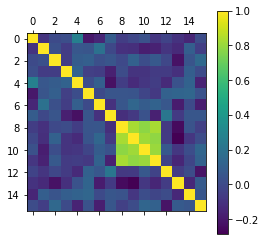

In [16]:
from brainiak.matnormal.mnrsa import MNRSA
model_matnorm = MNRSA(time_cov=time_cov, space_cov=space_cov, n_nureg=3)

model_matnorm.fit(true_Y, true_X)
plt.matshow(model_matnorm.C_)
plt.colorbar()

## Latent design matrices: PCA, CCA / SRM, TFA, and ISFC

The true innovation of a shared framework comes when starting to see the commonalities among methods. For example, consider what happens if the known design matrix $X$ is replaced with an unknown latent time series $S$, yielding the following model: 

$$
Y \sim \mathcal{MN}(SB, I, I). 
$$

In this model, we no longer know the design matrix, and the brain volume is now a weighted sum of unknown time series, with unknown weights. It turns out that this is precisely the model for probabilistic PCA, and there is nothing stopping us from implementing it in our framework: 

In [29]:
# Generate data
from sklearn.datasets import make_sparse_coded_signal
import numpy as np
np.random.seed(1)

features = 5
voxels = 100
TRs = 50

X, B, S = make_sparse_coded_signal(n_samples=TRs, n_components=features, n_features=voxels, n_nonzero_coefs=3)


(100, 50)

In [27]:
S.shape

(100, 5)

In [28]:
B.shape

(5, 50)